In [1]:
import torch
from torchvision import datasets, transforms
from torchvision.models import resnet18
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import Subset, random_split
from collections import defaultdict

In [2]:
# 数据预处理
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop((224, 224), scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 加载数据
data_dir = "./chest_xray"
train_dataset = datasets.ImageFolder(data_dir + "/train", transform=transform)
val_dataset = datasets.ImageFolder(data_dir + "/val", transform=transform)
test_dataset = datasets.ImageFolder(data_dir + "/test", transform=transform)

In [3]:
# 数据采样函数
def sample_subset(dataset, num_samples_per_class):
    class_indices = defaultdict(list)
    for idx, (_, label) in enumerate(dataset):
        class_indices[label].append(idx)
    sampled_indices = [idx for indices in class_indices.values() for idx in indices[:num_samples_per_class]]
    return Subset(dataset, sampled_indices)

train_subset = sample_subset(train_dataset, 800)
test_subset = sample_subset(test_dataset, 600)

val_size = int(0.2 * len(test_subset))  # 验证集大小为测试集的 20%
test_size = len(test_subset) - val_size
test_subset, val_subset = random_split(test_subset, [test_size, val_size])

train_loader = torch.utils.data.DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_subset, batch_size=16, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_subset, batch_size=32, shuffle=False)

In [4]:
# 模型定义
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, 2)
)
model = model.to(device)

d:\Anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.00001, weight_decay=0.001)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)  
epochs = 20

Epoch 1/20, Train Loss: 0.5468, Train Acc: 0.7625, Val Loss: 0.5670, Val Acc: 0.7097
Epoch 2/20, Train Loss: 0.3121, Train Acc: 0.9200, Val Loss: 0.3582, Val Acc: 0.8710
Epoch 3/20, Train Loss: 0.2139, Train Acc: 0.9356, Val Loss: 0.3603, Val Acc: 0.8306
Epoch 4/20, Train Loss: 0.1482, Train Acc: 0.9625, Val Loss: 0.3451, Val Acc: 0.8790
Epoch 5/20, Train Loss: 0.1271, Train Acc: 0.9631, Val Loss: 0.3526, Val Acc: 0.8548
Epoch 6/20, Train Loss: 0.1035, Train Acc: 0.9712, Val Loss: 0.3457, Val Acc: 0.8710
Epoch 7/20, Train Loss: 0.1198, Train Acc: 0.9637, Val Loss: 0.3003, Val Acc: 0.8952
Epoch 8/20, Train Loss: 0.1010, Train Acc: 0.9688, Val Loss: 0.3592, Val Acc: 0.8790
Epoch 9/20, Train Loss: 0.0883, Train Acc: 0.9731, Val Loss: 0.3239, Val Acc: 0.8790
Epoch 10/20, Train Loss: 0.0863, Train Acc: 0.9800, Val Loss: 0.3552, Val Acc: 0.8871
Epoch 11/20, Train Loss: 0.0933, Train Acc: 0.9731, Val Loss: 0.3207, Val Acc: 0.8952
Epoch 12/20, Train Loss: 0.0806, Train Acc: 0.9800, Val Loss: 0

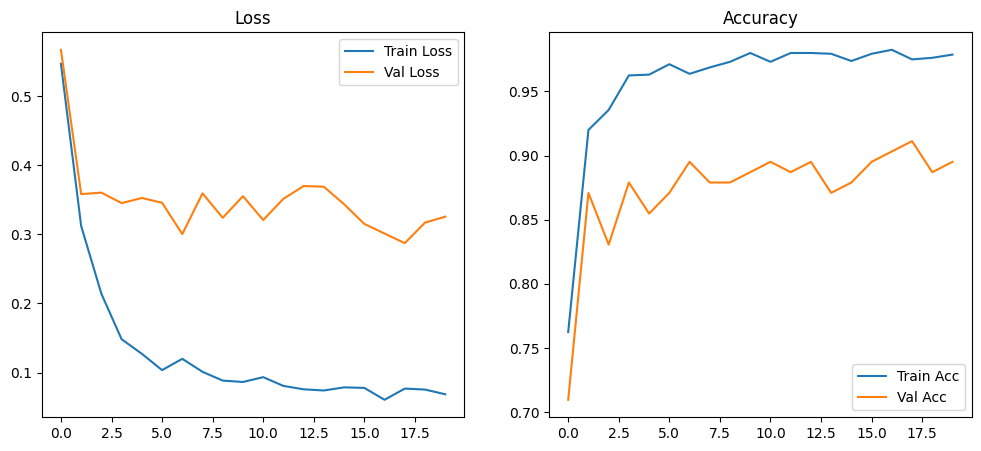

In [6]:
# 训练与验证函数
def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs):
    train_loss_history, train_acc_history = [], []
    val_loss_history, val_acc_history = [], []

    for epoch in range(epochs):
        # 训练阶段
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = correct / total
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)

        # 验证阶段
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = correct / total
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)

        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        scheduler.step()

    # 分开绘制损失和准确率
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_history, label="Train Loss")
    plt.plot(val_loss_history, label="Val Loss")
    plt.legend()
    plt.title("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(train_acc_history, label="Train Acc")
    plt.plot(val_acc_history, label="Val Acc")
    plt.legend()
    plt.title("Accuracy")

    plt.show()

# 训练模型
train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs)

In [7]:
# 测试模型
def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=test_dataset.classes))

    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

# 评估模型
evaluate_model(model, test_loader)

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.97      0.72      0.83       189
   PNEUMONIA       0.86      0.99      0.92       311

    accuracy                           0.89       500
   macro avg       0.91      0.86      0.87       500
weighted avg       0.90      0.89      0.88       500

Confusion Matrix:
[[137  52]
 [  4 307]]
